In [111]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import csv
from datetime import datetime, timedelta
from dateutil.relativedelta import *
from sklearn import preprocessing
import numpy as np
from scipy import sparse
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GMM
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.lda import LDA
from sklearn.qda import QDA

from sklearn import linear_model
from sklearn import naive_bayes
import pandas as pd
import xgboost as xgb
import time

In [112]:
dtypes = {"Date": datetime, "StateHoliday": np.dtype(str), "SchoolHoliday": np.dtype(int)}

# The read_csv returns an error when reading the stores data because of missing values but
# works when I don't specify the dtypes
store_dtypes = {"CompetitionSinceYear": np.dtype(int), "CompetitionSinceMonth": np.dtype(int), 
                "Promo2SinceYear": np.dtype(int), "Promo2SinceWeek": np.dtype(int)}
data = pd.read_csv('data/train.csv', dtype=dtypes, parse_dates=[2])
stores = pd.read_csv('data/store.csv')

test = pd.read_csv('data/test.csv', dtype=dtypes, parse_dates=[3])

In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 77.6+ MB


In [114]:
# remove rows with sales of 0
data = data[data.Sales > 0]

# extract sales to separate Series
sales = data.Sales

# remove Sales and Customers columns
data.drop(['Sales','Customers'], axis=1, inplace=True)

# check Open column and set to open if NaN
data.Open.fillna(1, inplace=True)

In [115]:
# Clean up NaN values

# Set competition distance to 0 if NaN
stores.CompetitionDistance.fillna(0, inplace=True)

# Set CompetitionOpenSince values to 0 if NaN
stores.CompetitionOpenSinceMonth.fillna(0, inplace=True)
stores.CompetitionOpenSinceYear.fillna(0, inplace=True)

# Set Promo2Since values to 0 if NaN
stores.Promo2SinceWeek.fillna(0, inplace=True)
stores.Promo2SinceYear.fillna(0, inplace=True)

# Set PromoInterval value to the string 'None' if NaN
stores.PromoInterval.fillna('None', inplace=True)

In [116]:
def recodeCategorical_asInt(df, fn, newfn):
    df[newfn] = pd.Categorical.from_array(df[fn]).codes
    return df

In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017190
Data columns (total 7 columns):
Store            844338 non-null int64
DayOfWeek        844338 non-null int64
Date             844338 non-null datetime64[ns]
Open             844338 non-null int64
Promo            844338 non-null int64
StateHoliday     844338 non-null object
SchoolHoliday    844338 non-null int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 51.5+ MB


In [118]:
data = recodeCategorical_asInt(data, 'SchoolHoliday', 'SchoolHolidayVal')
data = recodeCategorical_asInt(data, 'StateHoliday', 'StateHolidayVal')
data['DayOfYear'] = data.Date.dt.dayofyear

data.drop('SchoolHoliday', axis=1, inplace=True)
data.drop('StateHoliday', axis=1, inplace=True)
# data.drop('DayOfWeek', axis=1, inplace=True)
data.drop('Date', axis=1, inplace=True)

In [119]:
stores = recodeCategorical_asInt(stores, 'StoreType', 'StoreTypeVal')
stores = recodeCategorical_asInt(stores, 'Assortment', 'AssortmentVal')
stores = recodeCategorical_asInt(stores, 'PromoInterval', 'PromoIntervalVal')

stores.drop('StoreType', axis=1, inplace=True)
stores.drop('Assortment', axis=1, inplace=True)
stores.drop('PromoInterval', axis=1, inplace=True)

In [120]:
# perform a left outer join of the data and stores dataframes
all_data = pd.merge(data, stores, on='Store', how='left')

In [121]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 16 columns):
Store                        844338 non-null int64
DayOfWeek                    844338 non-null int64
Open                         844338 non-null int64
Promo                        844338 non-null int64
SchoolHolidayVal             844338 non-null int8
StateHolidayVal              844338 non-null int8
DayOfYear                    844338 non-null int64
CompetitionDistance          844338 non-null float64
CompetitionOpenSinceMonth    844338 non-null float64
CompetitionOpenSinceYear     844338 non-null float64
Promo2                       844338 non-null int64
Promo2SinceWeek              844338 non-null float64
Promo2SinceYear              844338 non-null float64
StoreTypeVal                 844338 non-null int8
AssortmentVal                844338 non-null int8
PromoIntervalVal             844338 non-null int8
dtypes: float64(5), int64(6), int8(5)
memory usage: 81.3 MB


In [122]:
# Make our own test and train data sets to play with

# take the data from the all_data dataframe and sales dataframe
X_train, X_test, Y_train, Y_test = train_test_split(all_data, sales, test_size=0.10, random_state=42)

In [87]:
from sklearn.neighbors import KNeighborsClassifier

neighbors = 10
clf = KNeighborsClassifier(neighbors)
clf.fit(X_train.as_matrix(), Y_train.as_matrix())


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=10, p=2, weights='uniform')

In [98]:
m = clf.predict(X_train)


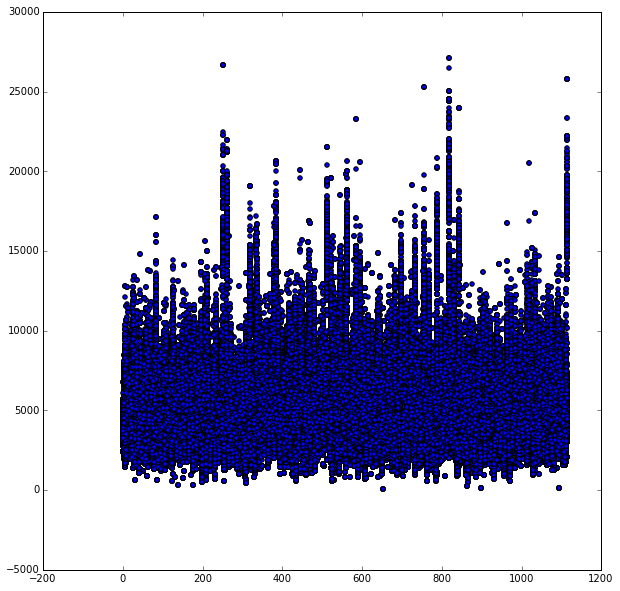

In [110]:
fig = plt.figure(figsize=(10,10))
p = plt.subplot(1,1,1)
p.scatter(X_train.Store, m)
plt.show()

In [140]:
X_train.CompetitionDistance = 

/Users/rcordell/Documents/MIDS/W207/W207env/lib/python2.7/site-packages/pandas/core/generic.py:2177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [141]:
comps = 5
gm_mod = GMM(n_components = comps)
gm_mod.fit(X_train)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=5, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)

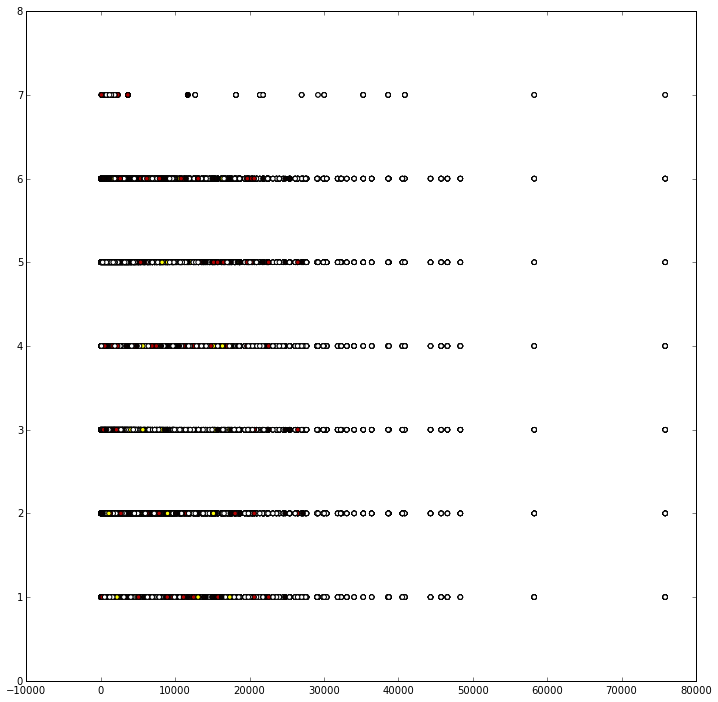

In [142]:
fig = plt.figure(figsize=(12,12))
y_hat = gm_mod.predict(X_test)
p = plt.subplot(1,1,1)
p.scatter(X_test.CompetitionDistance, X_test.DayOfWeek, c=y_hat, cmap=plt.cm.hot)